In [228]:
import pandas as pd
import numpy as np
np.random.seed(10)
import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from scipy.stats import rankdata

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn import svm

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight

from os import cpu_count

from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = 12, 8

pd.options.display.width = 500
n_jobs = max(cpu_count()-1, 1)

In [45]:
train = pd.read_csv("../../../data/modulbank/train.csv", sep='\t')
test = pd.read_csv("../../../data/modulbank/test.csv", sep='\t')

In [10]:
profile = pp.ProfileReport(train)
profile.to_file(outputfile="statistic_train.html")

profile = pp.ProfileReport(test)
profile.to_file(outputfile="statistic_test.html")

In [5]:
def make_file(y_pred, filename):
    submission = pd.Series (y_pred, name='_VAL_' )
    submission.to_csv(filename, index_label='_ID_', header =True )

In [46]:
def clean_data(train, test):
    
    train.drop('Unnamed: 0', axis=1, inplace=True)
    test.drop(['Unnamed: 0', '0'], axis=1, inplace=True)

    filter_test_const_cols = ['129', '130', '137', '138', '303', '305', '5', '141', '149',
                              '150', '164', '178', '186', '188', '192', '291', '301']
    
    for col in filter_test_const_cols:
        train = train[train[col] == 0].drop(col, axis=1)
    
    train = train[train['11'] == 1].drop('11', axis=1)
    test.drop(filter_test_const_cols + ['11'], axis=1, inplace=True)
    
    remove_const_cols = ['140', '152', '160']
#     repeated_cols = [ '9', '153']
    train.drop(remove_const_cols, axis=1, inplace=True)
    test.drop(remove_const_cols, axis=1, inplace=True)
    print(train.shape, test.shape)
    
    return train, test

In [47]:
train, test = clean_data(train, test)

(30379, 325) (4166, 324)


### Split data

In [48]:
X = train.drop('0', axis=1)
y = train['0']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15, 
                                                  random_state=42,
                                                  stratify=y)

In [40]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True,)

### Baseline on Logregression

In [49]:
lr = LogisticRegression(tol=0.9, 
                        C=100, 
                        random_state=42,
                        solver='newton-cg', 
                        class_weight='balanced')
lr.fit(X_train,  y_train)
roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1])

0.7352291709911138

- all features: 0.7241 / cv: 0.73
- clean data: 0.7350
- clean data (not delete corr feature): 0.7352

In [41]:
from os import cpu_count

n_jobs = max(cpu_count()-1, 1)
lr = LogisticRegression(
    random_state=42
)

scores_lr = cross_val_score(
    estimator=lr,
    X=X,
    y=y,
    scoring='roc_auc',
    cv=kf,
    n_jobs=n_jobs
).mean()
print('LR scoring: {:.2f}'.format(scores_lr))

LR scoring: 0.73


### Baseline Random Forest

In [42]:
rf = RandomForestClassifier(n_estimators=200, 
                            random_state=42,
                            min_samples_leaf=7,
                            min_samples_split=10,)

scores_rf = cross_val_score(
                estimator=rf,
                X=X,
                y=y,
                scoring='roc_auc',
                cv=kf,
                n_jobs=n_jobs
            ).mean()
print('RF scoring: {:.2f}'.format(scores_rf))

RF scoring: 0.73


## Baseline on xgboost

In [15]:
import xgboost as xgb

In [50]:
clf = xgb.XGBClassifier(
                   max_depth=6,
                   objective='reg:logistic',
                   eval_metric='auc',
                   reg_alpha=1, 
                   reg_lambda=1.2,
                   silent = 1,
                   colsample_bytree=0.7,
                   seed = 42,
                   eta=0.42,
                   learning_rate=0.1,
                       )
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.6821
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.707421
[2]	validation_0-auc:0.712759
[3]	validation_0-auc:0.713385
[4]	validation_0-auc:0.714893
[5]	validation_0-auc:0.718791
[6]	validation_0-auc:0.719455
[7]	validation_0-auc:0.721377
[8]	validation_0-auc:0.722085
[9]	validation_0-auc:0.72549
[10]	validation_0-auc:0.726738
[11]	validation_0-auc:0.726615
[12]	validation_0-auc:0.727762
[13]	validation_0-auc:0.727878
[14]	validation_0-auc:0.728045
[15]	validation_0-auc:0.730084
[16]	validation_0-auc:0.730694
[17]	validation_0-auc:0.731645
[18]	validation_0-auc:0.731925
[19]	validation_0-auc:0.732449
[20]	validation_0-auc:0.733895
[21]	validation_0-auc:0.734281
[22]	validation_0-auc:0.734199
[23]	validation_0-auc:0.734593
[24]	validation_0-auc:0.735489
[25]	validation_0-auc:0.735918
[26]	validation_0-auc:0.736933
[27]	validation_0-auc:0.737689
[28]	validation_0-auc:0.737376
[29]	validation_0-auc:0.73834
[30]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.42, eval_metric='auc', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:logistic', random_state=0, reg_alpha=1,
       reg_lambda=1.2, scale_pos_weight=1, seed=42, silent=1, subsample=1)

- 0.738 - all features - baseline
- 0.752429 - filter constant LB 0.75920944

In [59]:
xgb_predictions = clf.predict_proba(test.drop(['_ID_', '0'], axis=1))[:, 1]
make_file(xgb_predictions, 'xgb_tune.csv')

### Baseline on LGBm

In [ ]:
import lightgbm as lgb

In [212]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'metric': { 'auc'},
    'num_leaves': 45,
    'learning_rate': 0.108,
    'feature_fraction': 0.55,
    'bagging_fraction': 0.55,
    'bagging_freq': 6,
    'seed' : 42,
        
    #regularization
    'colsample_bytree': 0.75,
    'subsample': 0.8,
    'min_data_in_leaf': 6,
    
    #categorical features
    'min_data_per_group': 50
}

lgbm_model = lgb.LGBMClassifier(**params)
lgbm_model.fit(X_train, y_train, 
               eval_set=[(X_val, y_val)], 
               eval_metric='auc',
               early_stopping_rounds=10)

[1]	valid_0's auc: 0.682155
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.701388
[3]	valid_0's auc: 0.70778
[4]	valid_0's auc: 0.718335
[5]	valid_0's auc: 0.718435
[6]	valid_0's auc: 0.722409
[7]	valid_0's auc: 0.721488
[8]	valid_0's auc: 0.721858
[9]	valid_0's auc: 0.722541
[10]	valid_0's auc: 0.723266
[11]	valid_0's auc: 0.722821
[12]	valid_0's auc: 0.722787
[13]	valid_0's auc: 0.723053
[14]	valid_0's auc: 0.726115
[15]	valid_0's auc: 0.727876
[16]	valid_0's auc: 0.730429
[17]	valid_0's auc: 0.732655
[18]	valid_0's auc: 0.732903
[19]	valid_0's auc: 0.731955
[20]	valid_0's auc: 0.732318
[21]	valid_0's auc: 0.734159
[22]	valid_0's auc: 0.733696
[23]	valid_0's auc: 0.734712
[24]	valid_0's auc: 0.735105
[25]	valid_0's auc: 0.735557
[26]	valid_0's auc: 0.737223
[27]	valid_0's auc: 0.738537
[28]	valid_0's auc: 0.740843
[29]	valid_0's auc: 0.740125
[30]	valid_0's auc: 0.741273
[31]	valid_0's auc: 0.740395
[32]	valid_0's auc: 0.740834
[33]	valid_0's auc: 

LGBMClassifier(bagging_fraction=0.55, bagging_freq=6, boosting_type='gbdt',
        class_weight=None, colsample_bytree=0.75, feature_fraction=0.55,
        learning_rate=0.108, max_depth=-1, metric={'auc'},
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=6,
        min_data_per_group=50, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=45, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1, task='train')

In [208]:
roc_auc_score(y_val, lgbm_model.predict_proba(X_val)[:, 1])

0.7486730124840615

In [ ]:
lgbm_predictions = lgbm_model.predict_proba(X_val)[:, 1]
make_file(lgbm_predictions, 'lgb_tune.csv')

### Avg random seed xgb

In [269]:
models={}
seeds = [21, 177, 42]

for s in seeds:
    models[s] = xgb.XGBClassifier(
                   max_depth=6,
                   objective='reg:logistic',
                   eval_metric='auc',
                   reg_alpha=1, 
                   reg_lambda=1.2,
                   silent = 1,
                   colsample_bytree=0.7,
                   seed = s,
                   eta=0.42,
                   learning_rate=0.1,
                       )

    models[s].fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.683276
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.711206
[2]	validation_0-auc:0.713562
[3]	validation_0-auc:0.717164
[4]	validation_0-auc:0.718853
[5]	validation_0-auc:0.721596
[6]	validation_0-auc:0.719728
[7]	validation_0-auc:0.72399
[8]	validation_0-auc:0.724494
[9]	validation_0-auc:0.725833
[10]	validation_0-auc:0.7252
[11]	validation_0-auc:0.727095
[12]	validation_0-auc:0.72827
[13]	validation_0-auc:0.728515
[14]	validation_0-auc:0.730097
[15]	validation_0-auc:0.731037
[16]	validation_0-auc:0.731909
[17]	validation_0-auc:0.732313
[18]	validation_0-auc:0.733246
[19]	validation_0-auc:0.734622
[20]	validation_0-auc:0.734724
[21]	validation_0-auc:0.73581
[22]	validation_0-auc:0.736865
[23]	validation_0-auc:0.737219
[24]	validation_0-auc:0.73726
[25]	validation_0-auc:0.738806
[26]	validation_0-auc:0.739368
[27]	validation_0-auc:0.739518
[28]	validation_0-auc:0.739562
[29]	validation_0-auc:0.739705
[30]	validation_0-auc:

[77]	validation_0-auc:0.752429
[78]	validation_0-auc:0.752319
[79]	validation_0-auc:0.752064
[80]	validation_0-auc:0.751627
[81]	validation_0-auc:0.751633
[82]	validation_0-auc:0.751586
[83]	validation_0-auc:0.751848
[84]	validation_0-auc:0.751698
[85]	validation_0-auc:0.751955
[86]	validation_0-auc:0.751863
[87]	validation_0-auc:0.752134
Stopping. Best iteration:
[77]	validation_0-auc:0.752429



In [271]:
predictions = []
for s, model in models.items():
#     predictions.append( np.array(models[s].predict_proba(X_val)[:, 1]) )
    predictions.append( np.array(models[s].predict_proba(test)[:, 1]) )
    print(roc_auc_score(y_val ,models[s].predict_proba(X_val)[:, 1]))

0.7476074686910021
0.7482628077770858
0.7521338881805033


In [258]:
result = rankdata(predictions[0]) + rankdata(predictions[1]) + rankdata(predictions[2])
roc_auc_score(y_val , result)

0.7523464038720689

In [263]:
result = 0.15 * predictions[0] + 0.15 * predictions[1] + 0.7* predictions[2]
roc_auc_score(y_val , result)

0.7530890556066252

In [272]:
result = 0.15 * predictions[0] + 0.15 * predictions[1] + 0.7* predictions[2]
# LB 0.75920944; here 0.753089
make_file(result, 'xgb_random_seed_weighted_only_train.csv')

### Try Catboost

In [281]:
from catboost import CatBoostClassifier

In [307]:
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.2,
                           eval_metric='AUC',
                           use_best_model=False,
                           random_seed =42,
                           depth=5,
                           od_type='Iter',
                           boosting_type='Plain',
                           reg_lambda=1.2,
                           rsm=0.9,
                           loss_function='Logloss',
                          )

model.fit(X_train, y_train, 
          eval_set=(X_val, y_val),)

0:	learn: 0.6734900	test: 0.6786745	best: 0.6786745 (0)	total: 143ms	remaining: 2m 23s
1:	learn: 0.6858324	test: 0.6956322	best: 0.6956322 (1)	total: 273ms	remaining: 2m 16s
2:	learn: 0.6937696	test: 0.6954884	best: 0.6956322 (1)	total: 449ms	remaining: 2m 29s
3:	learn: 0.6999361	test: 0.6951894	best: 0.6956322 (1)	total: 610ms	remaining: 2m 31s
4:	learn: 0.7060708	test: 0.6989865	best: 0.6989865 (4)	total: 799ms	remaining: 2m 38s
5:	learn: 0.7120485	test: 0.7071163	best: 0.7071163 (5)	total: 942ms	remaining: 2m 35s
6:	learn: 0.7186236	test: 0.7131402	best: 0.7131402 (6)	total: 1.12s	remaining: 2m 38s
7:	learn: 0.7198434	test: 0.7133208	best: 0.7133208 (7)	total: 1.27s	remaining: 2m 37s
8:	learn: 0.7213599	test: 0.7152675	best: 0.7152675 (8)	total: 1.44s	remaining: 2m 38s
9:	learn: 0.7232405	test: 0.7168555	best: 0.7168555 (9)	total: 1.59s	remaining: 2m 37s
10:	learn: 0.7255814	test: 0.7179182	best: 0.7179182 (10)	total: 1.8s	remaining: 2m 41s
11:	learn: 0.7272284	test: 0.7197921	best:

93:	learn: 0.7937429	test: 0.7396455	best: 0.7401029 (81)	total: 23.5s	remaining: 3m 46s
94:	learn: 0.7942143	test: 0.7398185	best: 0.7401029 (81)	total: 23.8s	remaining: 3m 46s
95:	learn: 0.7945491	test: 0.7400927	best: 0.7401029 (81)	total: 24.1s	remaining: 3m 47s
96:	learn: 0.7950949	test: 0.7400508	best: 0.7401029 (81)	total: 24.4s	remaining: 3m 47s
97:	learn: 0.7952862	test: 0.7402564	best: 0.7402564 (97)	total: 24.6s	remaining: 3m 46s
98:	learn: 0.7955916	test: 0.7403763	best: 0.7403763 (98)	total: 24.8s	remaining: 3m 45s
99:	learn: 0.7962241	test: 0.7407088	best: 0.7407088 (99)	total: 25.1s	remaining: 3m 45s
100:	learn: 0.7965562	test: 0.7407803	best: 0.7407803 (100)	total: 25.3s	remaining: 3m 45s
101:	learn: 0.7970382	test: 0.7407625	best: 0.7407803 (100)	total: 25.6s	remaining: 3m 45s
102:	learn: 0.7977506	test: 0.7403869	best: 0.7407803 (100)	total: 25.9s	remaining: 3m 45s
103:	learn: 0.7982688	test: 0.7407912	best: 0.7407912 (103)	total: 26.1s	remaining: 3m 44s
104:	learn: 0

### Try ExtraTreesClassifier

In [217]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=42,
                              max_depth=20,
                              min_samples_leaf=3,
                              max_features= 0.6, #'sqrt',
                              n_jobs=3
                             )

forest.fit(X_train,  y_train)
roc_auc_score(y_val, forest.predict_proba(X_val)[:, 1])

0.7455574336012021

### Simple ensemble

In [308]:
et_val_pr = forest.predict_proba(X_val)[:,1]
lgbm_val_pr = lgbm_model.predict_proba(X_val)[:, 1]
cat_val_pr = model.predict_proba(X_val)[:, 1]
xgb_val_pr = clf.predict_proba(X_val)[:, 1]

### Rank avarage

In [309]:
res = rankdata(et_val_pr) + rankdata(lgbm_val_pr) +  rankdata(cat_val_pr) + rankdata(xgb_val_pr)
roc_auc_score(y_val, res)

0.7608826155574666

### Weighted mean

In [312]:
weighted_mean_predictions = 0.1 * et_val_pr + 0.3 * lgbm_val_pr + 0.3 * xgb_val_pr + 0.3 * cat_val_pr
roc_auc_score(y_val, weighted_mean_predictions)

0.7593900634911223

In [487]:
pred_mean = []

for et, lg, c, xg in zip(et_val_pr, lgbm_val_pr, cat_val_pr, xgb_val_pr):
    pred_mean.append(np.mean( [et, lg, c, xg]) )

print(roc_auc_score(y_val, pred_mean))

0.7613890289186083


### Test weighted mean

In [463]:
et_test_pr = forest.predict_proba(test)[:,1]
lgbm_test_pr = lgbm_model.predict_proba(test)[:, 1]
cat_test_pr = model.predict_proba(test)[:, 1]
xgb_test_pr = clf.predict_proba(test)[:, 1]

pred_geom_test = []
for et, lg, c, xg in zip(et_test_pr, lgbm_test_pr, cat_test_pr, xgb_test_pr):
    pred_geom_test.append(np.sqrt( et*lg*c*xg) )
    
make_file(pred_geom_test, 'pred_geom.csv')

### Try stack

In [481]:
X_train_stacked = X_train.copy()
X_val_stacked = X_val.copy()
X_test_stacked = test.copy()


X_train_stacked["xgb"] = clf.predict_proba(X_train)[:,1]
X_train_stacked["cat"] = model.predict_proba(X_train)[:,1]
X_train_stacked["lgbm"] = lgbm_model.predict_proba(X_train)[:,1]
X_train_stacked["et"] = forest.predict_proba(X_train)[:,1]

X_val_stacked["xgb"]  = xgb_val_pr
X_val_stacked["cat"]  = cat_val_pr
X_val_stacked["lgbm"] = lgbm_val_pr
X_val_stacked["et"]   = et_val_pr

X_test_stacked["xgb"] = xgb_test_pr
X_test_stacked["cat"] = cat_test_pr
X_test_stacked["lgbm"] = lgbm_test_pr
X_test_stacked["et"] = et_test_pr

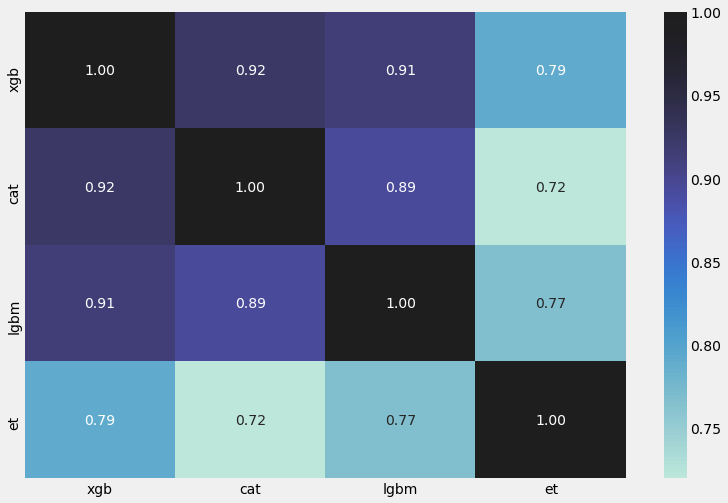

In [483]:
preds = X_train_stacked[['xgb', 'cat', 'lgbm', 'et']]
sns.heatmap(preds.corr(), annot=True, fmt='.2f', center = True)

In [475]:
et_stack = ExtraTreesClassifier(n_estimators=200, 
                          random_state=42,
                          max_depth=14, 
                          min_samples_leaf=3,
                          max_features= 'sqrt',
                          n_jobs=-1,  
                          min_samples_split=2,
                        )

et_stack.fit(X_train_stacked, y_train)
roc_auc_score(y_val, et_stack.predict_proba(X_val_stacked)[:, 1])

0.7610793161277993

In [477]:
et_stack_pred = et_stack.predict_proba(X_test_stacked)[:, 1]
make_file(et_stack_pred, 'et_stack_pred.csv')